<a href="https://colab.research.google.com/github/sajin2002/CVPR/blob/main/CrossValidationGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import necessary packages


In [69]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
import tensorflow as tf

#Mount Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading in Images

In [20]:
cat_files = glob('/content/drive/MyDrive/DatasetForColab/Animals/cat/*.png')
panda_files = glob('/content/drive/MyDrive/DatasetForColab/Animals/panda/*.png')
dolphin_files = glob('/content/drive/MyDrive/DatasetForColab/Animals/dolphin/*.png')

In [21]:
print(len(cat_files))
print(len(panda_files))
print(len(dolphin_files))

432
216
216


In [19]:
path = '/content/drive/MyDrive/DatasetForColab/Animals/'

In [16]:
categories = os.listdir(path)

In [36]:
print(categories)

['cat', 'dolphin', 'panda']


In [105]:
dataset = []

In [106]:
for category in categories:
    data_path = os.path.join(path, category)
    print("Loading from:", data_path)
    count = 0

    for img in os.listdir(data_path):
        if count >= 200:
            break

        img_path = os.path.join(data_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img_array is not None:
            img_resized = cv2.resize(img_array, (256, 256))  # Now safe, img_array not None
            dataset.append([img_resized, category])
            count += 1
        else:
            print(f"Warning: Failed to load image {img_path}")


Loading from: /content/drive/MyDrive/DatasetForColab/Animals/cat
Loading from: /content/drive/MyDrive/DatasetForColab/Animals/dolphin
Loading from: /content/drive/MyDrive/DatasetForColab/Animals/panda


In [107]:
len(dataset)

600

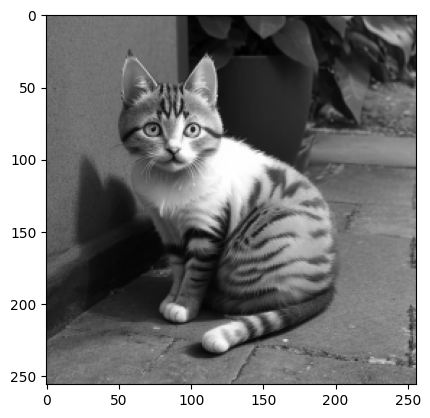

In [108]:
plt.imshow(dataset[0][0], cmap='gray')

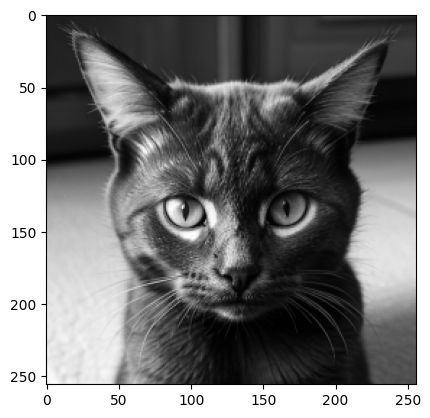

In [109]:
random.shuffle(dataset)
plt.imshow(dataset[0][0], cmap='gray')

In [110]:
folds = []
start_index = 0
count = len(dataset) / 5
for i in range(0,5):
  folds.append(dataset[start_index:int(count)])
  start_index = int(count)
  count += len(dataset) / 5

In [111]:
print(len(folds))
print(len(folds[0]))

5
120


In [112]:
from collections import Counter

def mostCommonElement(lst, k):
    labels = [x[1] for x in lst]  # Extract labels only
    return Counter(labels[:k]).most_common(1)[0][0]

average_accuracies = []
fold_accuracies = []

# Loop over k values from 1 to 30
for k in range(1, 31):
    for i in range(5):  # 5-fold cross-validation
        prediction = []
        valid_dataset = folds[i]
        # Combine all folds except the i-th as training set
        train_dataset = [item for j in range(5) if j != i for item in folds[j]]

        # For each image in validation set
        for valid_img, valid_label in valid_dataset:
            distance_matrix = []

            # Compute L2 distance to all training images
            for train_img, train_label in train_dataset:
                l2_distance = np.linalg.norm(np.array(train_img) - np.array(valid_img))
                distance_matrix.append([l2_distance, train_label])

            # Sort by distance and predict using k nearest labels
            distance_matrix.sort()
            predicted_label = mostCommonElement(distance_matrix, k)

            # Compare predicted and actual
            prediction.append(int(predicted_label == valid_label))

        accuracy = sum(prediction) / len(prediction)
        fold_accuracies.append(accuracy)

    # Compute average of all folds for this k
    average_accuracies.append(sum(fold_accuracies[-5:]) / 5)

# Output diagnostics
print("Total k-values evaluated:", len(average_accuracies))
print("Total fold accuracies stored:", len(fold_accuracies))

Total k-values evaluated: 30
Total fold accuracies stored: 150


In [113]:
average_accuracies = [round(num,2) for num in average_accuracies]
fold_accuracies = [round(num,2) for num in fold_accuracies]

for k, average_accuracy in enumerate(average_accuracies, start=1):
    print(f"For k={k} Average Accuracy={average_accuracy}")

For k=1 Average Accuracy=0.5
For k=2 Average Accuracy=0.5
For k=3 Average Accuracy=0.49
For k=4 Average Accuracy=0.49
For k=5 Average Accuracy=0.48
For k=6 Average Accuracy=0.47
For k=7 Average Accuracy=0.46
For k=8 Average Accuracy=0.46
For k=9 Average Accuracy=0.45
For k=10 Average Accuracy=0.45
For k=11 Average Accuracy=0.45
For k=12 Average Accuracy=0.43
For k=13 Average Accuracy=0.42
For k=14 Average Accuracy=0.42
For k=15 Average Accuracy=0.42
For k=16 Average Accuracy=0.42
For k=17 Average Accuracy=0.41
For k=18 Average Accuracy=0.4
For k=19 Average Accuracy=0.39
For k=20 Average Accuracy=0.4
For k=21 Average Accuracy=0.39
For k=22 Average Accuracy=0.38
For k=23 Average Accuracy=0.38
For k=24 Average Accuracy=0.37
For k=25 Average Accuracy=0.37
For k=26 Average Accuracy=0.36
For k=27 Average Accuracy=0.36
For k=28 Average Accuracy=0.36
For k=29 Average Accuracy=0.36
For k=30 Average Accuracy=0.36


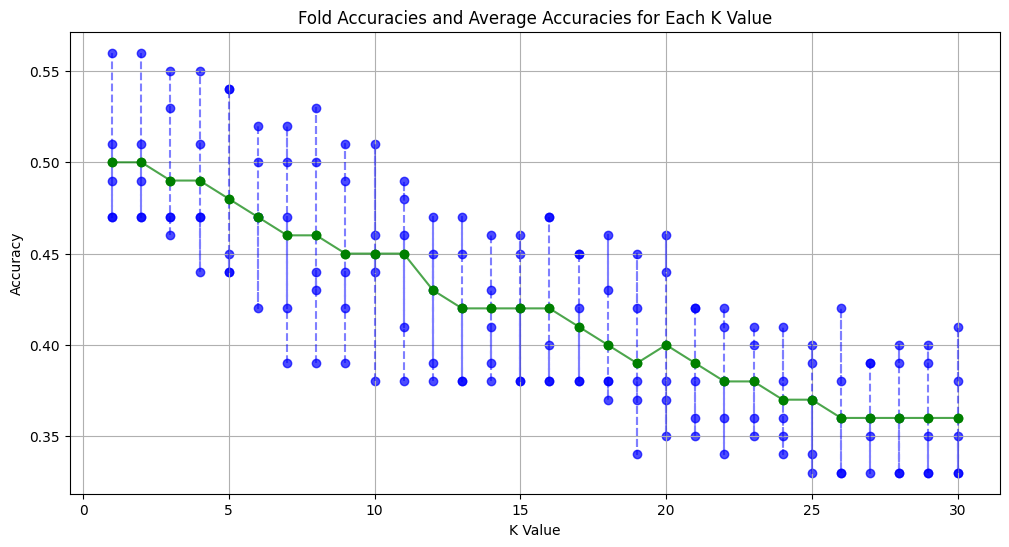

In [114]:
folds_per_k = 5
num_k_values = 30
plt.figure(figsize=(12, 6))

for k in range(num_k_values):
    start = k * folds_per_k
    end = start + folds_per_k
    plt.scatter([k + 1] * folds_per_k, fold_accuracies[start:end], color='blue', alpha=0.7)
    plt.plot([k + 1] * folds_per_k, fold_accuracies[start:end], linestyle='--', color='blue', alpha=0.5)

plt.plot(range(1, num_k_values + 1), average_accuracies, color='green', marker='o', label='Average Accuracy', alpha=0.7)
plt.scatter(range(1, num_k_values + 1), average_accuracies, color='green', zorder=10)

plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Fold Accuracies and Average Accuracies for Each K Value')
plt.grid(True)
plt.show()